In [1]:
import numpy as np
import cv2
import os
from PIL import Image
import glob
import matplotlib.pyplot as plt
from datasets import Dataset
import random
#from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import median
import torch
from torch.nn.functional import threshold, normalize
from google.cloud import storage

/Users/ryantenbarge/.pyenv/versions/3.10.6/envs/solar_potential_map/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# We need to load all of the training images into a numpy array. One array for originals, and one for masks
original_filelist = glob.glob('../data_for_ml/original/*.png')
print(f'Number of original images: {len(original_filelist)}')
original_filelist = sorted(original_filelist)
masked_filelist = glob.glob('../data_for_ml/grayscale/*.png')
masked_filelist = sorted(masked_filelist)
print(f'Number of masked images: {len(masked_filelist)}')

Number of original images: 7200
Number of masked images: 7200


In [16]:
masked_filelist[:10]

['../data_for_ml/grayscale/1.png',
 '../data_for_ml/grayscale/10.png',
 '../data_for_ml/grayscale/100.png',
 '../data_for_ml/grayscale/1000.png',
 '../data_for_ml/grayscale/1001.png',
 '../data_for_ml/grayscale/1002.png',
 '../data_for_ml/grayscale/1003.png',
 '../data_for_ml/grayscale/1004.png',
 '../data_for_ml/grayscale/1005.png',
 '../data_for_ml/grayscale/1006.png']

In [17]:
original_filelist[:10]

['../data_for_ml/original/1.png',
 '../data_for_ml/original/10.png',
 '../data_for_ml/original/100.png',
 '../data_for_ml/original/1000.png',
 '../data_for_ml/original/1001.png',
 '../data_for_ml/original/1002.png',
 '../data_for_ml/original/1003.png',
 '../data_for_ml/original/1004.png',
 '../data_for_ml/original/1005.png',
 '../data_for_ml/original/1006.png']

In [5]:
# This will work to read in everything into a numpy array, but
# it throws an error due to differing pic sizes
# for now, let's try excluding the larger 572 pixel images
original_images_array = np.array([np.asarray((Image.open(fname))) for fname in original_filelist if '-' not in fname])
original_images_array.shape

(6000, 286, 286, 3)

In [6]:
# Now let's do the same for the masks, again ignoring the 572 sized images
masks_array = np.array([np.asarray((Image.open(fname)), dtype=float) for fname in masked_filelist if '-' not in fname])
masks_array.shape

(6000, 286, 286)

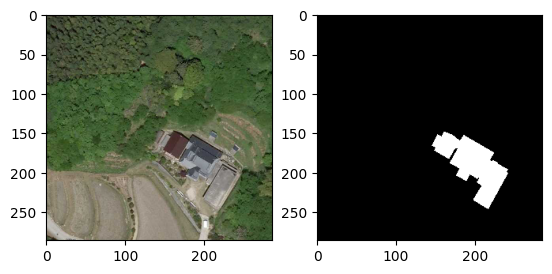

In [25]:
# The two Numpy arrays see to have all the pics in the same order and match up well
fig, ax = plt.subplots(1, 2)
ax[0].imshow(original_images_array[1])
ax[1].imshow(masks_array[1], cmap='gray')

In [7]:
masks_array[0,:,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
# rgb = cv2.cvtColor(masks_array[0, :,:], cv2.COLOR_GRAY2RGB)
# cv2.imshow(rgb)

# We may need to delete any images which have no masks in them. I can't do it yet without the black and white images

In [ ]:
# ### drop empty images here###
# # Create a list to store the indices of non-empty masks
# valid_indices = [i for i, mask in enumerate(masks_array) if mask.max() != 0]
# # Filter the image and mask arrays to keep only the non-empty pairs
# filtered_images = original_images_array[valid_indices]
# filtered_masks = masks_array[valid_indices]
# print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
# print("Mask shape:", filtered_masks.shape)

# Create a dataset object that will serve us input images and masks for the rest of the training

In [9]:
# Convert the NumPy arrays to pillow images and store them in a dictionary
dataset_dict = {
    'image': [Image.fromarray(img) for img in original_images_array],
    'label': [Image.fromarray(mask) for mask in masks_array]
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [10]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 6000
})

In [31]:
type(dataset_dict['label'])

list

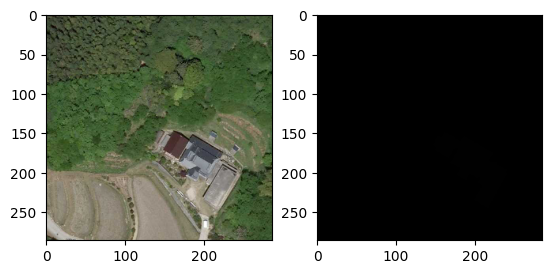

In [26]:
# For some reason now, the images are no longer in the correct matching order
fig, ax = plt.subplots(1, 2)
ax[0].imshow(dataset[1]['image'])
ax[1].imshow(dataset[1]['label'])

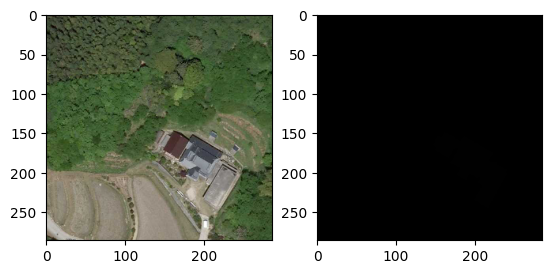

In [28]:
# This seems to be where the order is being messes up. In the dataset_dict!!
fig, ax = plt.subplots(1, 2)
ax[0].imshow(dataset_dict['image'][1])
ax[1].imshow(dataset_dict['label'][1])

Let's check to make sure our images and masks are loading correctly.

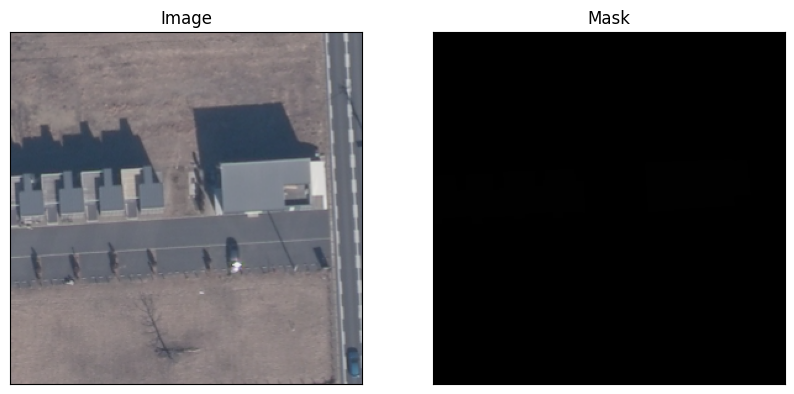

In [13]:
img_num = random.randint(0, original_images_array.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Next, we need to get bounding boxes from masks.

In [70]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [73]:

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [74]:
# Initalize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json: 100%|██████████| 466/466 [00:00<00:00, 949kB/s]


In [75]:
# Create an instance of the SAM Dataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

# I think the only reason the below error is showing up is because the masks are not black and white yet

In [79]:
train_dataset[0]

ValueError: too many values to unpack (expected 2)

In [77]:
example = train_dataset[0]
example.items()
#for k,v in example.items():
  #print(k,v.shape)

ValueError: too many values to unpack (expected 2)

In [81]:
# Create a DataLoader instance for the training dataset
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [82]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

ValueError: too many values to unpack (expected 2)

In [83]:
batch["ground_truth_mask"].shape

NameError: name 'batch' is not defined

In [84]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained('facebook/sam-vit-base')

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith('vision_encoder') or name.startswith('prompt_encoder'):
        param.requires_grad_(False)

config.json: 100%|██████████| 6.57k/6.57k [00:00<00:00, 8.51MB/s]
model.safetensors: 100%|██████████| 375M/375M [00:17<00:00, 21.6MB/s] 


In [87]:
# initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# The following can only be done once we have the black and white masks!!

In [ ]:
#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {np.mean(np.array(epoch_losses))}')

In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "../retrain_weights/solar_model_checkpoint.pth")
# storage_client = storage.Client("solar_roof_model_weights")
# bucket = storage_client.bucket("solar_roof_model_weights")
# blob = bucket.blob("model/model.pt")
# with blob.open("wb", ignore_flush=True) as f:
#     torch.save(obj, f)


# The next step will be to load in our saved model and see how it does...

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_solar_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_solar_model.load_state_dict(torch.load("../retrain_data/solar_model_checkpoint.pth"))


In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_solar_model.to(device)

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, masks_array.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_solar_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_solar_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Now, let us load a new image and segment it using our trained model. Note that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [ ]:
#Apply a trained model on large image -> use one of our testing images here
large_test_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/small_dataset_for_training/images/12_training_mito_images.tif")
large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap

In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

In [ ]:
patches.shape

In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_solar_model.eval()

# forward pass
with torch.no_grad():
  outputs = my_solar_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()